# Classifying Chest X-Ray Images (Pneumonia)
### Markowitz Working NB

Dataset from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [20]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

from markowitz_functions import get_images, preprocess_dense_data, visualize_training_results, get_class_weights

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading images from local folders

The original `val` folder from Kaggle contained only 8 images *each* from Normal and Pneumonia, which is not a sufficient size for validation. 

Rather than adding files to that folder to increase the size of the validation set, we have chosen to move **all** images into the `train` folder. We will then use the `val_split` parameter in `flow_from_directory` to instantiate a validation set.

In [23]:
# Filepaths
train_dir = 'chest_xray/train'
# validation_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/' 

In [3]:
# Check functionality and num images
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
train_normal_dir

'chest_xray/train/NORMAL'

In [4]:
# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

In [5]:
print('There are', len(os.listdir(train_normal_dir)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia_dir)), 'pneumonia images in the training set')

There are 1349 normal images in the training set
There are 3883 pneumonia images in the training set


### EDA: Image Samples and Metadata

In [6]:
# Get list of filenames of all training images
train_norm_filenames = os.listdir(train_normal_dir)
train_pneum_filenames = os.listdir(train_pneumonia_dir)

In [7]:
# Make list of full filepaths to each image
train_normal_filepaths = [os.path.join(train_normal_dir, name) for name in train_norm_filenames]
train_pneumonia_filepaths = [os.path.join(train_pneumonia_dir, name) for name in train_pneum_filenames]

In [8]:
train_normal_filepaths[:10]

['chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0427-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0561-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1110-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0757-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1326-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-0736-0001.jpeg']

In [10]:
# Get training images of normal and pneumonia
# Read each file in as an image
train_normal_images = get_images(train_normal_dir)
train_pneumonia_images = get_images(train_pneumonia_dir)

#### Show the first 5 images from each set:

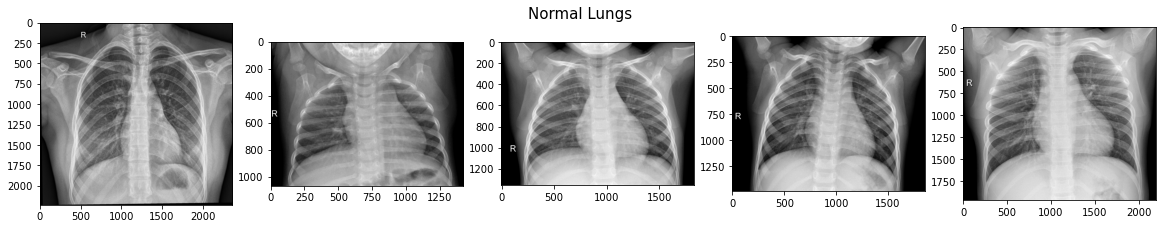

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_normal_images[i], cmap='gray')
fig.suptitle('Normal Lungs', fontsize=15, y=.8)
fig.tight_layout;

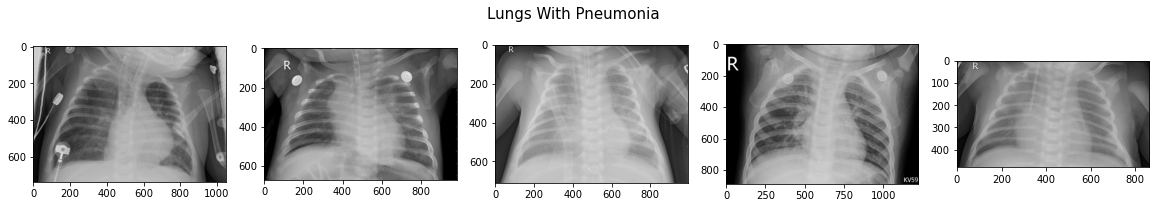

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_pneumonia_images[i], cmap='gray')
fig.suptitle('Lungs With Pneumonia', fontsize=15, y=.8)
fig.tight_layout;

**Notes:**
 - All photos are single-channel (black and white, not RGB)
 - All x-ray photos have 'R' to designate right-side lung
 - Pneumonia lungs have EKG(?) electrodes(?)--possible confounding factor for NN?
 - Pneumonia lungs look "cloudy" or "fuzzy" compared to Normal

From Kaggle:
> The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

Essentially, this means that bacterial pneumonia typically gathers in one area of the lungs, while viral penumonia is more spread out.

#### Metadata

In [13]:
# Dimensions of images
normal_img_shapes = [img.shape for img in train_normal_images]
pneumonia_img_shapes = [img.shape for img in train_pneumonia_images]

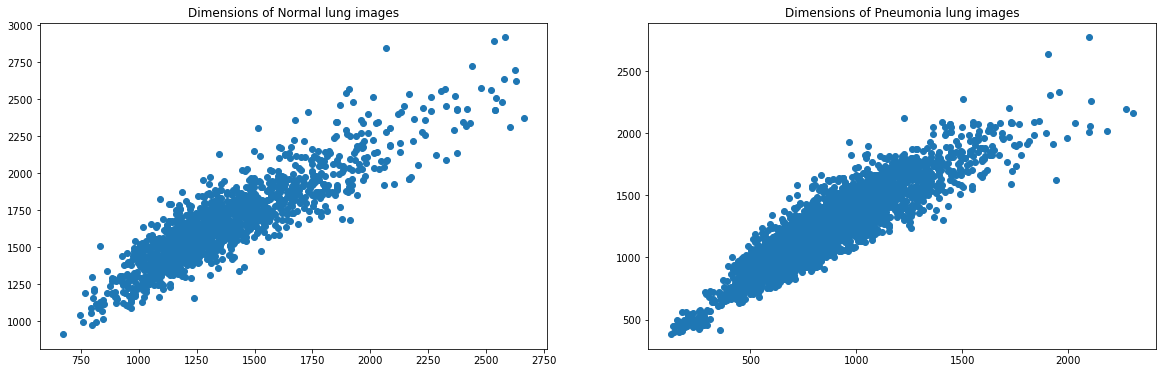

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Sizes of Normal lung images
ax1.scatter(x=[x[0] for x in normal_img_shapes], y=[x[1] for x in normal_img_shapes])
ax1.set_title('Dimensions of Normal lung images')

# Sizes of Pneumonia lung images
ax2.scatter(x=[x[0] for x in pneumonia_img_shapes], y=[x[1] for x in pneumonia_img_shapes])
ax2.set_title('Dimensions of Pneumonia lung images');

In [15]:
print('Smallest normal image dimension is ', np.min(normal_img_shapes))
print('Largest normal image dimension is ', np.max(normal_img_shapes))
print('Smallest pneumonia image dimension is ', np.min(pneumonia_img_shapes))
print('Largest pneumonia image dimension is ', np.max(pneumonia_img_shapes))

Smallest normal image dimension is  672
Largest normal image dimension is  2916
Smallest pneumonia image dimension is  (127, 384, 3)
Largest pneumonia image dimension is  (2304, 2160)


 - Overall linear relationships suggest similar aspect ratios, especially with smaller images (more variety with larger size images). 
 - Wild divergence in image size, though. The largest images are over 3x the size of the smallest images! How will this affect results/resizing? Does this mean we have to resize images to match the smallest image?
 - Pneumonia lung images have smaller sizes too (less than 500x500).

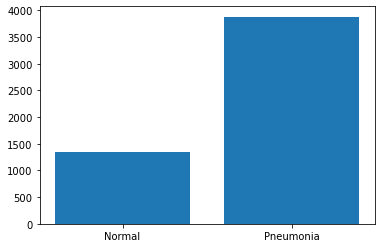

In [16]:
# Visualize class distribution in training data
plt.bar(x=['Normal', 'Pneumonia'], height=[len(train_normal_images), len(train_pneumonia_images)]);

Clearly not an even distribution! So many more pneumonia images, probably an over-representation.

## Loading images for modeling

We'll use the `ImageDataGenerator` class from Keras, as well as `flow_from_directory` to feed the images into the model.

In [14]:
def preprocess_dense_data(train_dir=train_dir, 
                          #val_dir=validation_dir, 
                          test_dir=test_dir, 
                          process_test=False,
                          target_size=(256, 256),
                          batch_size=100,
                          color_mode='grayscale',
                          class_mode='binary'):
    '''
    Prepare image data for fitting in a fully connected dense neural network by
    getting data from directories, scaling, and reshaping.
    
    Parameters: directories for training, validation, and testing data.
    
    Returns: X_train, X_val, X_test, train_labels, val_labels, test_labels
    '''
    # Param-dict for 'flow_from_directory'
    directory_kwargs = {'target_size':target_size,
                        'batch_size':batch_size,
                        'color_mode':color_mode,
                        'class_mode':class_mode}
    
    # Get data from directories and scale
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    train_generator = train_datagen.flow_from_directory(train_dir, subset='training', **directory_kwargs)
    val_generator = train_datagen.flow_from_directory(train_dir, subset='validation', **directory_kwargs)
    # val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir, **directory_kwargs)
    
    if process_test:
        test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **directory_kwargs)
    
    # Create the datasets
    train_images, train_labels = next(train_generator)
    val_images, val_labels = next(val_generator)
    if process_test:
        test_images, test_labels = next(test_generator)
    
    # Prepare images for modeling by reshaping
    def reshape_images(images):
        return images.reshape(images.shape[0], -1)
    
    X_train = reshape_images(train_images)
    X_val = reshape_images(val_images)

    if process_test:
        X_test = reshape_images(test_images)
        return X_train, X_val, X_test, train_labels, val_labels, test_labels
    else:
        return X_train, X_val, train_labels, val_labels
    

## First Simple Model

Using simple fully connected Dense layers, no fancy stuff, no convolutions yet.

In [17]:
from keras import models
from keras.layers import Dense

In [26]:
X_train, X_val, train_labels, val_labels = preprocess_dense_data(train_dir,
                                                                 target_size=(100, 100), 
                                                                 batch_size=50)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [27]:
# Instatiate model
model = models.Sequential()

# Add model layers
model.add(Dense(32, activation='relu', input_shape=(10000,)))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc', 'Recall'])

In [28]:
# Train the model
history = model.fit(X_train, train_labels, 
                    epochs=50,
                    batch_size=10,
                    validation_data=(X_val, val_labels))

Epoch 1/50
5/5 [==============================] - 0s 47ms/step - loss: 1.1762 - acc: 0.4600 - recall: 0.5588 - val_loss: 0.6541 - val_acc: 0.6800 - val_recall: 1.0000
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.6595 - acc: 0.6800 - recall: 1.0000 - val_loss: 0.6367 - val_acc: 0.6800 - val_recall: 1.0000
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 0.6461 - acc: 0.6800 - recall: 1.0000 - val_loss: 0.6244 - val_acc: 0.6800 - val_recall: 1.0000
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 0.6426 - acc: 0.6800 - recall: 1.0000 - val_loss: 0.6197 - val_acc: 0.6800 - val_recall: 1.0000
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 0.6375 - acc: 0.6800 - recall: 1.0000 - val_loss: 0.6179 - val_acc: 0.6800 - val_recall: 1.0000
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.6379 - acc: 0.6800 - recall: 1.0000 - val_loss: 0.6172 - val_acc: 0.6800 - val_recall: 1.0000
Epo

5/5 [==============================] - 0s 6ms/step - loss: 0.2770 - acc: 0.9200 - recall: 1.0000 - val_loss: 0.3724 - val_acc: 0.8200 - val_recall: 1.0000


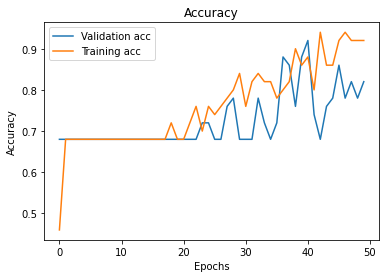

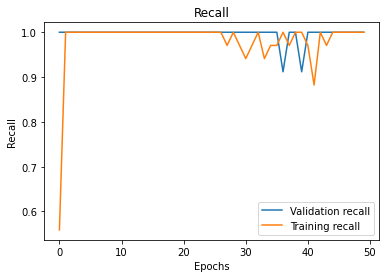

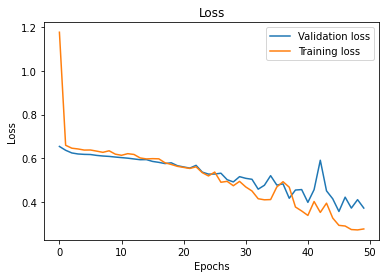

Training eval:
2/2 [==============================] - 0s 1ms/step - loss: 0.2538 - acc: 0.8800 - recall: 1.0000

Validation eval:
2/2 [==============================] - 0s 1ms/step - loss: 0.3724 - acc: 0.8200 - recall: 1.0000


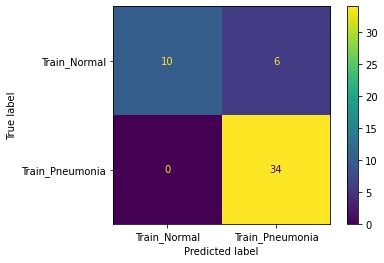

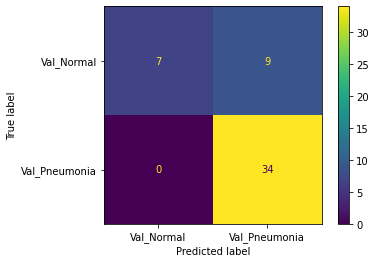

In [29]:
# Visualize the results
visualize_training_results(history, model, X_train, train_labels, X_val, val_labels)

**Analysis:**
Our FSM runs! Huzzah! However, the accuracy and loss are all over the place and overall poor, likely because:
 - we are only training it on 50 images
 - loss of data from resizing the images down to 150x150
 - class imbalance (in favor of Pneumonia lungs)

In [57]:
model.save('first-simple-model.h5')

## Iterating

Our model can definitely improve! The overfitting is likely due to way too few images being used in training, combined with a serious class imbalance in favor of the target class. Also, our model is very basic (only 1 hidden layer), so adding a 2nd hidden layer will likely help.

In [31]:
i1_X_train, i1_X_val, i1_train_labels, i1_val_labels = preprocess_dense_data(train_dir)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


### i1 (iteration one):
 - Bump up size of images to 256x256
 - Increase number of images to 100
 - Add a 2nd hidden layer

In [74]:
# Instatiate model
i1_model = models.Sequential()

# Add model layers - Let's add another hidden layer this time
i1_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i1_model.add(Dense(16, activation='relu'))
i1_model.add(Dense(1, activation='sigmoid'))

# Compile
i1_model.compile(optimizer='sgd',
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

In [75]:
# Train the model
i1_history = i1_model.fit(i1_X_train, i1_train_labels, 
                    epochs=50,
                    batch_size=10,
                    validation_data=(i1_X_val, i1_val_labels))

Epoch 1/50
10/10 [==============================] - 0s 29ms/step - loss: 0.7231 - acc: 0.8000 - recall: 1.0000 - val_loss: 0.5814 - val_acc: 0.7400 - val_recall: 1.0000
Epoch 2/50
10/10 [==============================] - 0s 11ms/step - loss: 0.5097 - acc: 0.8000 - recall: 1.0000 - val_loss: 0.5576 - val_acc: 0.7400 - val_recall: 1.0000
Epoch 3/50
10/10 [==============================] - 0s 11ms/step - loss: 0.5005 - acc: 0.8000 - recall: 1.0000 - val_loss: 0.5793 - val_acc: 0.7400 - val_recall: 1.0000
Epoch 4/50
10/10 [==============================] - 0s 12ms/step - loss: 0.4639 - acc: 0.8000 - recall: 1.0000 - val_loss: 0.5476 - val_acc: 0.7400 - val_recall: 1.0000
Epoch 5/50
10/10 [==============================] - 0s 10ms/step - loss: 0.4858 - acc: 0.8000 - recall: 1.0000 - val_loss: 0.5089 - val_acc: 0.7400 - val_recall: 1.0000
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 0.4481 - acc: 0.8000 - recall: 1.0000 - val_loss: 0.6193 - val_acc: 0.7400 - val_r

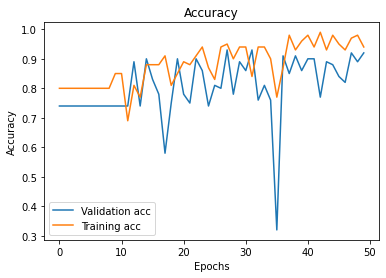

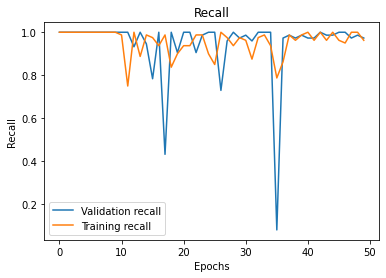

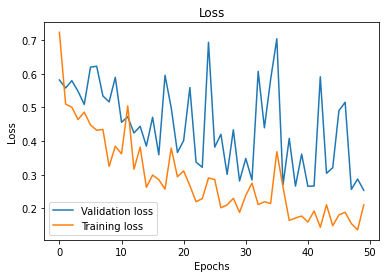

Training eval:
4/4 [==============================] - 0s 3ms/step - loss: 0.1688 - acc: 0.9800 - recall: 0.9750

Validation eval:
4/4 [==============================] - 0s 3ms/step - loss: 0.2539 - acc: 0.9200 - recall: 0.9730


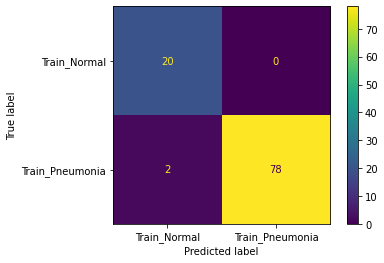

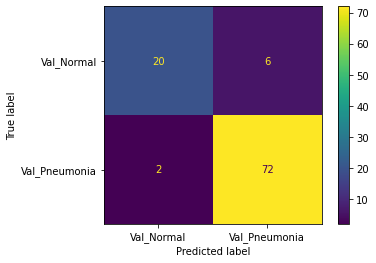

In [89]:
visualize_training_results(i1_history, i1_model, i1_X_train, i1_train_labels, i1_X_val, i1_val_labels)

It's slightly less overfit, but the accuracy/loss curves are still all over the place.

In [84]:
i1_model.save('i1_model.h5')

### i2 (iteration two):
 - Include `class_weight` parameter during model fitting/training
 - Increase number of images to 500
 - Add a 3nd hidden layer

To get the class weights, I've gone back and added the option to return a dictionary `class_weights` from the `preprocess_dense_data` function.

In [32]:
# Preprocess the data
i2_X_train, i2_X_val, i2_train_labels, i2_val_labels = preprocess_dense_data(train_dir, batch_size=500)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [33]:
# Get the class weights
i2_class_weights = get_class_weights(i2_train_labels)

In [68]:
# Instatiate model
i2_model = models.Sequential()

# Add model layers - Same as previous model
i2_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i2_model.add(Dense(16, activation='relu'))
i2_model.add(Dense(1, activation='sigmoid'))

# Compile
i2_model.compile(optimizer='sgd',
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

In [69]:
# Train the model - This time incorporating class_weights
i2_history = i2_model.fit(i2_X_train, i2_train_labels, 
                          epochs=50,
                          batch_size=10,
                          class_weight=i2_class_weights,
                          validation_data=(i2_X_val, i2_val_labels))

Epoch 1/50
50/50 [==============================] - 1s 12ms/step - loss: 0.7237 - acc: 0.5240 - recall: 0.5317 - val_loss: 0.9707 - val_acc: 0.2460 - val_recall: 0.0000e+00
Epoch 2/50
50/50 [==============================] - 0s 9ms/step - loss: 0.6807 - acc: 0.4320 - recall: 0.3113 - val_loss: 0.6463 - val_acc: 0.8540 - val_recall: 0.9708
Epoch 3/50
50/50 [==============================] - 0s 9ms/step - loss: 0.6478 - acc: 0.6060 - recall: 0.5923 - val_loss: 0.5255 - val_acc: 0.8420 - val_recall: 0.8302
Epoch 4/50
50/50 [==============================] - 0s 8ms/step - loss: 0.5554 - acc: 0.6880 - recall: 0.6474 - val_loss: 0.3507 - val_acc: 0.8320 - val_recall: 0.9867
Epoch 5/50
50/50 [==============================] - 0s 8ms/step - loss: 0.5511 - acc: 0.6920 - recall: 0.6391 - val_loss: 0.5241 - val_acc: 0.6820 - val_recall: 0.5836
Epoch 6/50
50/50 [==============================] - 0s 8ms/step - loss: 0.5635 - acc: 0.6860 - recall: 0.6143 - val_loss: 0.4380 - val_acc: 0.7500 - val_re

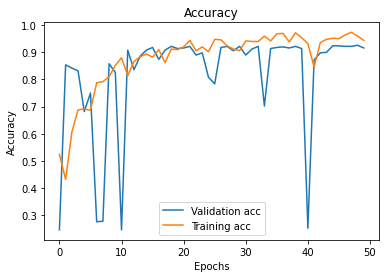

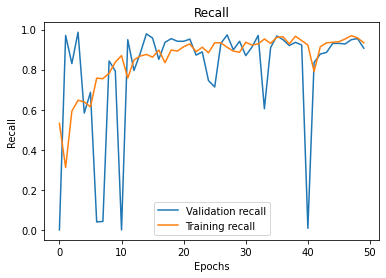

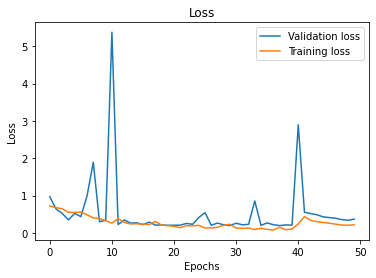

Training eval:
16/16 [==============================] - 0s 6ms/step - loss: 0.2300 - acc: 0.9700 - recall: 0.9614

Validation eval:
16/16 [==============================] - 0s 5ms/step - loss: 0.3723 - acc: 0.9160 - recall: 0.9072


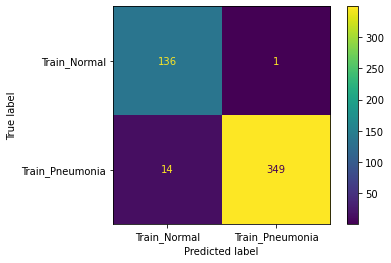

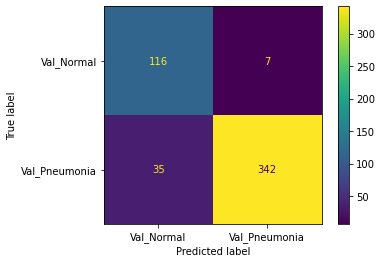

In [90]:
visualize_training_results(i2_history, i2_model, i2_X_train, i2_train_labels, i2_X_val, i2_val_labels)

In [85]:
i2_model.save('i2_model.h5')

Another improvement! Adding the `class_weight` parameter helped close the gap between training and validation data and increased overall accuracy. However, the metrics are still all over the place. Adding more data is likely to help, as could adding more hidden layers.

### i3 (iteration three):
 - Increase number of images to 2000
 - Add more hidden layers
 - Add l2 regularization to Dense layers (to help with overfitting)

In [77]:
from tensorflow.keras.regularizers import l2

In [79]:
i3_X_train, i3_X_val, i3_train_labels, i3_val_labels = preprocess_dense_data(train_dir, batch_size=2000)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [80]:
i3_class_weights = get_class_weights(i3_train_labels)

In [81]:
# Instatiate model
i3_model = models.Sequential()

# Add model layers - More layers and with l2 regularization
i3_model.add(Dense(32, activation='relu', input_shape=(256*256,)))
i3_model.add(Dense(20, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(12, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(12, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(8, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(4, activation='relu', kernel_regularizer=l2(l2=0.01)))
i3_model.add(Dense(1, activation='sigmoid', ))

# Compile
i3_model.compile(optimizer='sgd',
                 loss='binary_crossentropy',
                 metrics=['acc', 'Recall'])

In [82]:
# Train the model
i3_history = i3_model.fit(i3_X_train, i3_train_labels, 
                          epochs=100,
                          batch_size=32,
                          class_weight=i3_class_weights,
                          validation_data=(i3_X_val, i3_val_labels))

Epoch 1/100
63/63 [==============================] - 1s 18ms/step - loss: 1.3261 - acc: 0.7430 - recall: 0.9606 - val_loss: 1.1977 - val_acc: 0.7426 - val_recall: 1.0000
Epoch 2/100
63/63 [==============================] - 1s 14ms/step - loss: 1.2554 - acc: 0.7865 - recall: 0.9077 - val_loss: 1.0688 - val_acc: 0.7493 - val_recall: 1.0000
Epoch 3/100
63/63 [==============================] - 1s 13ms/step - loss: 1.1895 - acc: 0.7970 - recall: 0.8466 - val_loss: 1.3384 - val_acc: 0.2593 - val_recall: 0.0026
Epoch 4/100
63/63 [==============================] - 1s 13ms/step - loss: 1.2583 - acc: 0.6090 - recall: 0.5995 - val_loss: 0.9698 - val_acc: 0.8258 - val_recall: 0.9884
Epoch 5/100
63/63 [==============================] - 1s 13ms/step - loss: 1.0948 - acc: 0.8445 - recall: 0.8737 - val_loss: 0.9118 - val_acc: 0.8804 - val_recall: 0.9781
Epoch 6/100
63/63 [==============================] - 1s 13ms/step - loss: 1.0672 - acc: 0.7930 - recall: 0.7766 - val_loss: 1.1917 - val_acc: 0.5732 -

Epoch 49/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3740 - acc: 0.9440 - recall: 0.9369 - val_loss: 0.3620 - val_acc: 0.9435 - val_recall: 0.9497
Epoch 50/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3537 - acc: 0.9520 - recall: 0.9450 - val_loss: 0.3559 - val_acc: 0.9455 - val_recall: 0.9523
Epoch 51/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3521 - acc: 0.9480 - recall: 0.9403 - val_loss: 0.3503 - val_acc: 0.9474 - val_recall: 0.9549
Epoch 52/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3496 - acc: 0.9470 - recall: 0.9423 - val_loss: 0.3724 - val_acc: 0.9321 - val_recall: 0.9188
Epoch 53/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3464 - acc: 0.9515 - recall: 0.9477 - val_loss: 0.3861 - val_acc: 0.9187 - val_recall: 0.9008
Epoch 54/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3347 - acc: 0.9520 - recall: 0.9457 - val_loss: 0.3369 - val_acc: 0.

Epoch 97/100
63/63 [==============================] - 1s 13ms/step - loss: 0.1666 - acc: 0.9770 - recall: 0.9722 - val_loss: 0.2676 - val_acc: 0.9254 - val_recall: 0.9085
Epoch 98/100
63/63 [==============================] - 1s 13ms/step - loss: 0.1904 - acc: 0.9620 - recall: 0.9572 - val_loss: 0.2694 - val_acc: 0.9292 - val_recall: 0.9781
Epoch 99/100
63/63 [==============================] - 1s 13ms/step - loss: 0.1749 - acc: 0.9700 - recall: 0.9654 - val_loss: 0.3812 - val_acc: 0.8813 - val_recall: 0.8415
Epoch 100/100
63/63 [==============================] - 1s 13ms/step - loss: 0.1836 - acc: 0.9615 - recall: 0.9552 - val_loss: 0.2434 - val_acc: 0.9301 - val_recall: 0.9175


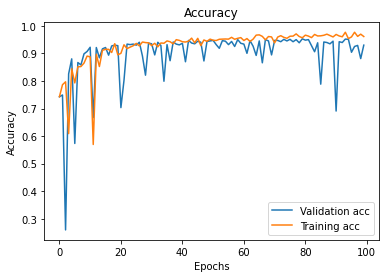

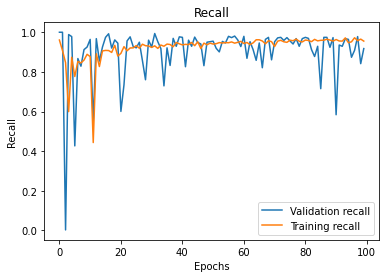

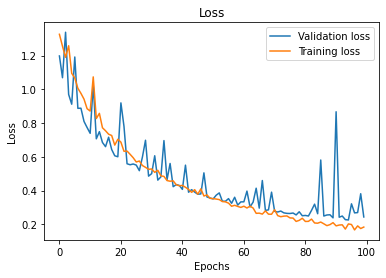

Training eval:
63/63 [==============================] - 0s 5ms/step - loss: 0.1737 - acc: 0.9700 - recall: 0.9593

Validation eval:
33/33 [==============================] - 0s 4ms/step - loss: 0.2434 - acc: 0.9301 - recall: 0.9175


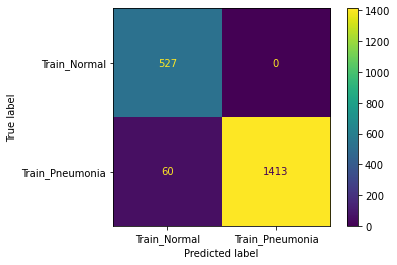

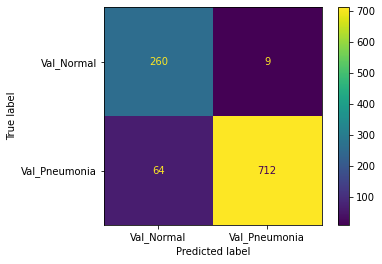

In [91]:
visualize_training_results(i3_history, i3_model, i3_X_train, i3_train_labels, i3_X_val, i3_val_labels)

In [86]:
i3_model.save('i3_model.h5')